In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import multiprocessing
import pandas as pd
import seaborn as sns
from mlflow import MlflowClient
import mlflow
import os
import sys
from pathlib import Path
cwd = Path.cwd()
parent = cwd.parent
sys.path.append(str(parent))
sys.path.append(os.path.abspath(os.path.join("..","Source")))

mlruns_path = Path("../mlruns").resolve() 
mlflow_uri = mlruns_path.as_uri()
mlflow.set_tracking_uri(mlflow_uri)


# 🤗
from transformers import AutoTokenizer



from sklearn.metrics import confusion_matrix 
# from nltk.corpus import stopwords  
from tqdm import tqdm
tqdm.pandas()
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

nw = multiprocessing.cpu_count()



client = MlflowClient(tracking_uri="http://localhost:8080")
os.environ["TF_KERAS"]='1'
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs disponibles :", tf.config.list_physical_devices("GPU"))
print("Version TF :", tf.__version__)

c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.10.1
Num GPUs Available:  1
GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version TF : 2.10.1


## Chargement du modèle complet

In [2]:
# Besoin de cette importation pour charger le modèle complet car il utilise une couche de transformers
from transformers import TFRobertaModel 


fullmodel3 = tf.keras.models.load_model(
    "../Models/Best_BERT_model_save_keras_v2",
    custom_objects={"TFRobertaModel": TFRobertaModel}
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [3]:
fullmodel3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_roberta_model_6 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, None                                         

# Creation du convertisseur TFlite (option conversion en `float16`)

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(fullmodel3)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\bassm\AppData\Local\Temp\tmp717l46un\assets


INFO:tensorflow:Assets written to: C:\Users\bassm\AppData\Local\Temp\tmp717l46un\assets


In [5]:
# Sauvegarde
with open("../exp_models/bert_model_f16.tflite", "wb") as f:
    f.write(tflite_model)

# Création du convertisseur TFlite (option `OPTIMIZE_FOR_SIZE`)

In [6]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(fullmodel3)
    
converter2.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model2 = converter2.convert()

INFO:tensorflow:Assets written to: C:\Users\bassm\AppData\Local\Temp\tmp4cbhi1pa\assets


INFO:tensorflow:Assets written to: C:\Users\bassm\AppData\Local\Temp\tmp4cbhi1pa\assets


In [7]:
with open("../exp_models/bert_model_opt_size.tflite", "wb") as f:
    f.write(tflite_model2)

# Chargement modèles TFlite

In [8]:
# Charger le modèle TFLite float16
interpreter_f16 = tf.lite.Interpreter(model_path="../exp_models/bert_model_f16.tflite")

input_details_f16 = interpreter_f16.get_input_details()
output_details_f16 = interpreter_f16.get_output_details()

print("Entrées :", input_details_f16)
print("Sorties :", output_details_f16)

Entrées : [{'name': 'serving_default_attention_mask:0', 'index': 0, 'shape': array([1, 1]), 'shape_signature': array([-1, -1]), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_input_ids:0', 'index': 1, 'shape': array([1, 1]), 'shape_signature': array([-1, -1]), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Sorties : [{'name': 'StatefulPartitionedCall:0', 'index': 1549, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_para

In [9]:
# Charger le modèle TFLite optimisé taille
interpreter_opt = tf.lite.Interpreter(model_path="../exp_models/bert_model_opt_size.tflite")

input_details_opt = interpreter_opt.get_input_details()
output_details_opt = interpreter_opt.get_output_details()

print("Entrées :", input_details_opt)
print("Sorties :", output_details_opt)

Entrées : [{'name': 'serving_default_attention_mask:0', 'index': 0, 'shape': array([1, 1]), 'shape_signature': array([-1, -1]), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_input_ids:0', 'index': 1, 'shape': array([1, 1]), 'shape_signature': array([-1, -1]), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Sorties : [{'name': 'StatefulPartitionedCall:0', 'index': 1345, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_para

# Import du toenizer directement depuis HF

In [10]:
tokenizer_loaded = AutoTokenizer.from_pretrained("Kapiche/twitter-roberta-base-sentiment")
tokenizer_loaded.save_pretrained("../exp_models/final_tokenizer")

('../exp_models/final_tokenizer\\tokenizer_config.json',
 '../exp_models/final_tokenizer\\special_tokens_map.json',
 '../exp_models/final_tokenizer\\vocab.json',
 '../exp_models/final_tokenizer\\merges.txt',
 '../exp_models/final_tokenizer\\added_tokens.json',
 '../exp_models/final_tokenizer\\tokenizer.json')

# Prediction à partir du modèle allegé

## Version `float16`

In [11]:


def predict_tflite_f16(sentence, max_len=64):
    # Tokenizer la phrase
    inputs = tokenizer_loaded(sentence, return_tensors="np", padding='max_length', max_length=max_len, truncation=True)

    # Resize + allocate
    interpreter_f16.resize_tensor_input(input_details_f16[0]['index'], [1, max_len])
    interpreter_f16.resize_tensor_input(input_details_f16[1]['index'], [1, max_len])
    interpreter_f16.allocate_tensors()

    # Injecter les tenseurs
    interpreter_f16.set_tensor(input_details_f16[0]['index'], inputs['attention_mask'])
    interpreter_f16.set_tensor(input_details_f16[1]['index'], inputs['input_ids'])

    # Inference
    interpreter_f16.invoke()
    output = interpreter_f16.get_tensor(output_details_f16 [0]['index'])
    return output

## Version `DEFAULT`

In [12]:


def predict_tflite_opt(sentence, max_len=64):
    # Tokenizer la phrase
    inputs = tokenizer_loaded(sentence, return_tensors="np", padding='max_length', max_length=max_len, truncation=True)

    # Resize + allocate
    interpreter_opt.resize_tensor_input(input_details_opt[0]['index'], [1, max_len])
    interpreter_opt.resize_tensor_input(input_details_opt[1]['index'], [1, max_len])
    interpreter_opt.allocate_tensors()

    # Injecter les tenseurs
    interpreter_opt.set_tensor(input_details_opt[0]['index'], inputs['attention_mask'])
    interpreter_opt.set_tensor(input_details_opt[1]['index'], inputs['input_ids'])

    # Inference
    interpreter_opt.invoke()
    output = interpreter_opt.get_tensor(output_details_opt[0]['index'])
    return output

# Prediction à partir du modèle complet 

In [13]:
    
def predict_fullmodel3(text):
    inputs = tokenizer_loaded(text, return_tensors="tf", padding=True, truncation=True, max_length=64)
    inputs = {k: tf.convert_to_tensor(v) for k, v in inputs.items()}
    preds = fullmodel3.predict(inputs, verbose=0)
    return preds


# Comparaison des écartes entre les deux modèles (Complet VS Lite)

## Chargement du dataset d'entrainement 

In [14]:
df = pd.read_csv('https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip',
                header=None,
                compression='zip',
                encoding='cp1252')

df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data_size = 1000

sample_df, _ = train_test_split(df, test_size=1-0.005, random_state=42, stratify=df['target'])
sample_df = sample_df.reset_index(drop=True)
print(f"Sample size: {sample_df.shape[0]} rows")
# On ne garde que les colonnes 'target' et 'text'
sample_df = sample_df[['target', 'text']]
sample_df["target"] = sample_df["target"].apply(lambda x: 0 if x == 0 else 1)
sample_df.to_csv('../Data/raw_data.csv', index=False)
dataset = mlflow.data.from_pandas(
    sample_df,
    source="../Data/raw_data.csv",
    name="dataset_v1"
)

# Data
X_raw = sample_df['text']
y = sample_df['target']


Sample size: 8000 rows


c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../Data/raw_data.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\ProgramData\anaconda3\envs\AI_env_P7_gpu\lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [15]:
sentences  = X_raw.to_list()

## Predictions sur le dataset d'entrainement 

In [16]:
import tqdm

results_full = [predict_fullmodel3(s) for s in tqdm.tqdm(sentences)]
results_lite_f16 = [predict_tflite_f16(s) for s in tqdm.tqdm(sentences)]
results_lite_opt = [predict_tflite_opt(s) for s in tqdm.tqdm(sentences)]


100%|██████████| 8000/8000 [1:34:31<00:00,  1.41it/s]


In [17]:
results_full_array = np.array([r[0] for r in results_full])
results_lite_f16_array = np.array([r[0] for r in results_lite_f16]) 
results_lite_opt_array = np.array([r[0] for r in results_lite_opt])

In [18]:
diff_array_f16 = results_full_array - results_lite_f16_array
diff_array_opt = results_full_array - results_lite_opt_array

<Axes: ylabel='Count'>

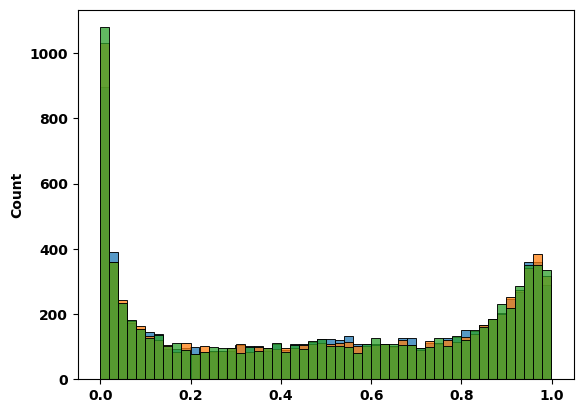

In [19]:
sns.histplot(results_full_array.flatten(), bins=50)
sns.histplot(results_lite_f16_array.flatten(), bins=50)
sns.histplot(results_lite_opt_array.flatten(), bins=50)

<Axes: ylabel='Count'>

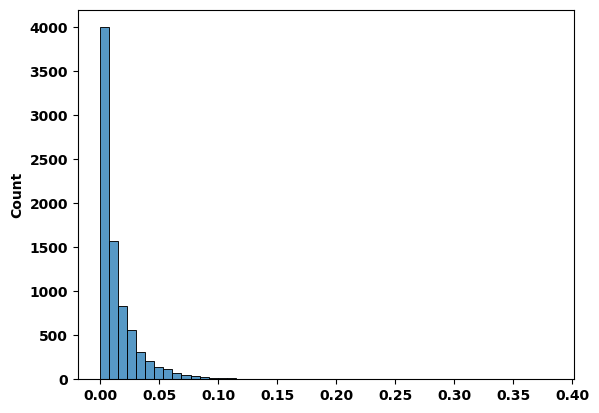

In [20]:
sns.histplot(np.abs(diff_array_f16.flatten()), bins=50)



<Axes: ylabel='Count'>

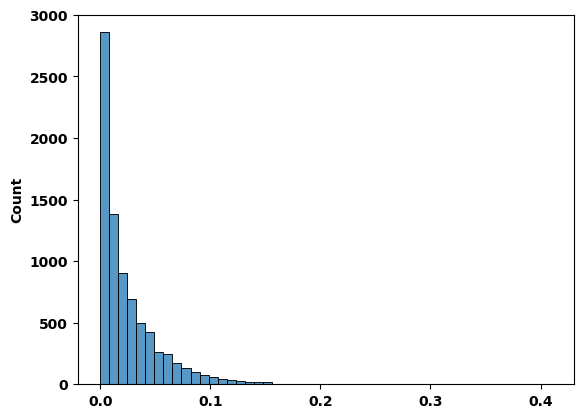

In [21]:
sns.histplot(np.abs(diff_array_opt.flatten()), bins=50)

# Accuracy par rapport au dataset 

In [22]:
y_pred_full = (results_full_array > 0.5).astype(int).flatten()
y_pred_f16 = (results_lite_f16_array > 0.5).astype(int).flatten()
y_pred_opt = (results_lite_opt_array > 0.5).astype(int).flatten()

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score,auc

acc_full = accuracy_score(y, y_pred_full)
print(f"Accuracy Full model: {acc_full}")
acc_f16 = accuracy_score(y, y_pred_f16)
print(f"Accuracy TFlite-f16 model: {acc_f16}")
acc_opt = accuracy_score(y, y_pred_opt)
print(f"Accuracy TFlite-optimized model: {acc_opt}")

Accuracy Full model: 0.82375
Accuracy TFlite-f16 model: 0.824625
Accuracy TFlite-optimized model: 0.826875


In [24]:
def find_best_threshold_accuracy(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100001)  # 100001 seuils entre 0 et 1
    best_t = 0.5
    best_acc = -1
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        acc = accuracy_score(y_true, preds)
        if acc > best_acc:
            best_acc = acc
            best_t = t
    return best_t, best_acc

# Exemple
best_t_full, best_acc_full = find_best_threshold_accuracy(y, results_full_array.flatten())
print(f"Seuil optimal pour accuracy : {best_t_full:.5f} | Accuracy = {best_acc_full:.4f}")

best_t_f16, best_acc_f16 = find_best_threshold_accuracy(y, results_lite_f16_array.flatten())
print(f"Seuil optimal pour accuracy TFlite-f16 : {best_t_f16:.5f} | Accuracy = {best_acc_f16:.4f}")

best_t_opt, best_acc_opt = find_best_threshold_accuracy(y, results_lite_opt_array.flatten())
print(f"Seuil optimal pour accuracy TFlite-optimized : {best_t_opt:.5f} | Accuracy = {best_acc_opt:.4f}")

Seuil optimal pour accuracy : 0.47763 | Accuracy = 0.8261
Seuil optimal pour accuracy TFlite-f16 : 0.45279 | Accuracy = 0.8273
Seuil optimal pour accuracy TFlite-optimized : 0.52621 | Accuracy = 0.8290


- L'optimisation du seuil permet de gagner environ $1\%$ d'accuracy pour tous les modèles. 
- L'accuracy entre le modèle TFlite-f16 et le modèle complet est quasi nulle (inférieure à $10^{-4}$)
- Le passage en modèle optimisé TFlite ne fait perdre que $0.6\%$ en accuracy. 

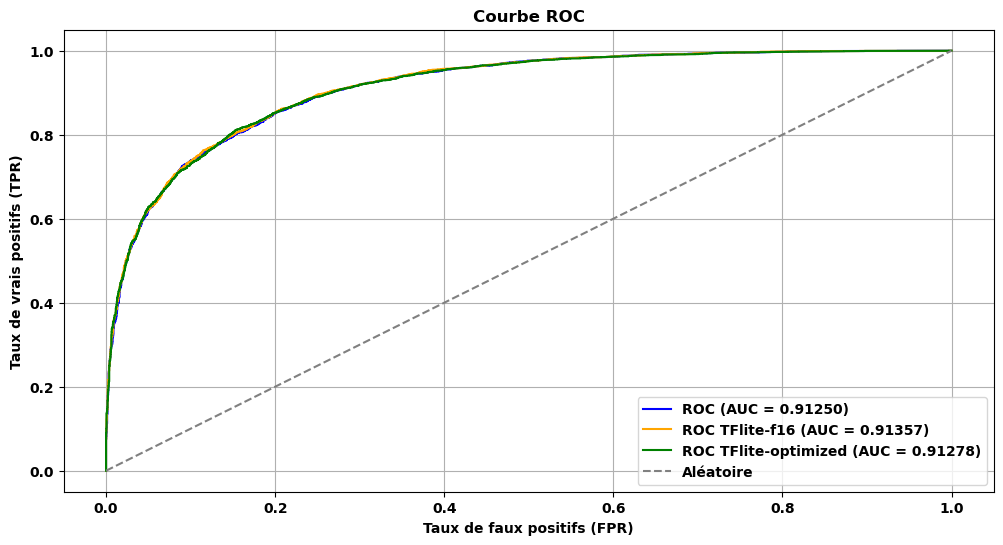

In [25]:
fpr_full, tpr_full, thresholds_full = roc_curve(y, results_full_array.flatten())
fpr_f16, tpr_f16, thresholds_f16 = roc_curve(y, results_lite_f16_array.flatten())
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y, results_lite_opt_array.flatten())

roc_auc_full = auc(fpr_full, tpr_full)
roc_auc_f16 = auc(fpr_f16, tpr_f16)
roc_auc_opt = auc(fpr_opt, tpr_opt)

plt.figure(figsize=(12,6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'ROC (AUC = {roc_auc_full:.5f})')
plt.plot(fpr_f16, tpr_f16, color='orange', label=f'ROC TFlite-f16 (AUC = {roc_auc_f16:.5f})')
plt.plot(fpr_opt, tpr_opt, color='green', label=f'ROC TFlite-optimized (AUC = {roc_auc_opt:.5f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



# Conclusion

On a ainsi un modèle fonctionnel dont la taille en mémoire est très inférieure à celle du modèle de base. Les erformances prédictives du modèle sont équivalentes (si on choisit l'option `float16`) au prix d'un temps d'inférence très supérieur (environ 10 fois plus long de réaliser un inférence avec ce modèle). Mais dans l'absolu cette contrainte n'est pas problématique car le temps d'inférence restera de toute manière bien inférieure à l'overhead du reste de l'application. 